# Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
#import food101 dataset from pytorch
from torchvision.datasets import Food101
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn

# Loading Food-101

In [27]:
#importing training set

#resize to
image_size = 224

#train transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees = 15),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.2),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()]) #,transforms.Normalize(mean=mean, std=std)])

#test transforms
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()]) #,transforms.Normalize(mean=mean, std=std)])

#import food101 dataset
train_data = Food101(root='data', split='train', download=True, transform=transform)
test_data = Food101(root='data', split='test', download=True, transform=test_transform)


from torch.utils.data import Subset
#cutting dataset into a tenth to test if training is working faster
#define your fraction (1 for whole dataset)
fraction = 1

dataset_size = len(train_data)
subset_size = int(dataset_size * fraction)
indices = np.random.choice(dataset_size, subset_size, replace=False)
train_data = Subset(train_data, indices)

dataset_size = len(test_data)
subset_size = int(dataset_size * fraction)
indices = np.random.choice(dataset_size, subset_size, replace=False)
test_data = Subset(test_data, indices)

In [18]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 68.8 MB/s eta 0:00:00:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# Model Training Function

In [3]:
from torchmetrics import Accuracy, MeanMetric

def modelTraining(model, criterion, optimizer, epochs, train_dataset, test_dataset, batch_size, image_size, channels, device):
    #create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    #place to store metrics
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs  = []

    train_acc_metric = Accuracy(task="multiclass", num_classes=101).to(device)
    train_loss_metric = MeanMetric().to(device)
    test_acc_metric = Accuracy(task="multiclass", num_classes=101).to(device)
    test_loss_metric = MeanMetric().to(device)

    #iterate over EPOCHS
    for i in range(epochs):
        model.train()

        batchNum = -1
        #iterate over TRAIN BATCHES
        for X_train, y_train in train_loader:
            batchNum += 1
            if batchNum % 10 == 0:
                print(f"Batch {batchNum}")

            #move data to device
            X_train, y_train = X_train.to(device), y_train.to(device)

            #make predictions
            y_pred = model(X_train.view(X_train.size(0), channels, image_size, image_size))
            #calculate loss
            #print(y_pred.shape)
            loss = criterion(y_pred, y_train)

            #backpropogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #update metrics
            train_acc_metric.update(y_pred, y_train)
            train_loss_metric.update(loss)

        #SAVE AND EVALUATE
        model.eval()
        #change me to match the file you want to save to!!
        torch.save(model.state_dict(), 'secondVersion.pth')
        #iterate over TEST BATCHES
        for X_test, y_test in test_loader:

            #move data to device
            X_test, y_test = X_test.to(device), y_test.to(device)

            #make predictions
            y_pred = model(X_test.view(X_test.size(0), channels, image_size, image_size))
            #calculate loss
            loss = criterion(y_pred, y_test)

            #update metrics
            test_acc_metric.update(y_pred, y_test)
            test_loss_metric.update(loss)

        print(f"Epoch {i+1}: Training Loss: {train_loss_metric.compute().item():.4f}, Training Accuracy: {train_acc_metric.compute().item():.4f}, Test Loss: {test_loss_metric.compute().item():.4f}, Test Accuracy: {test_acc_metric.compute().item():.4f}")

        #add to return lists
        train_losses.append(train_loss_metric.compute().item())
        test_losses.append(test_loss_metric.compute().item())
        train_accs.append(train_acc_metric.compute().item())
        test_accs.append(test_acc_metric.compute().item())

        train_acc_metric.reset()
        train_loss_metric.reset()
        test_acc_metric.reset()
        test_loss_metric.reset()



    return model, train_losses, test_losses, train_accs, test_accs



# From-Scratch ViT Code

In [4]:
#patch embedding block- turns an image into patches and embeds them
class PatchEmbed(nn.Module):
    def __init__(self, img_size, patch_size, in_channels = 3, embed_dim = 768): #assuming an RGB image and an embed dimension of 768b (like in original paper)
        #img_size = input image size
        #patch_size = dimensions of a single patch
        #in_channels = number of input channels
        #embed_dim = size of embedding vector (per patch)
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        #will use a 2d convolutional layer to extract each patch embedding (hence output channels being embed size)
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size = patch_size, stride = patch_size)

    def forward(self, x):
        #x is of shape (batch_size, in_channels, img_size, img_size)

        x = self.proj(x)
        #x is now of shape (batch_size, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2) #flatten along the second spacial dimension, turning the (n_patches square root) shape into its squared size n_patches
        #x is now of shape (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2) #now of shape (batch_size, n_patches, embed_dim), foo easier processing later
        return x

In [5]:
#attention module- processes the patches
class Attention(nn.Module):
    def __init__(self, dim, n_heads = 12, qkv_bias = True, attn_p = 0, proj_p = 0):
        #dim = input/output dimension of our tokens (embed dimension)
        #n_heads = number of attention heads
        #qkv_bias = whether or not a bias is included to query, key, value vectors (qkv --> "query key value")
        #attn_p = dropout probability for query, key, val
        #proj_p = dropout prob for output tensor
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads #each head needs a fraction of the full embedding size so that when we concat later the dimensionality is preserved
        self.scale = self.head_dim ** -0.5 #scale by key dim

        self.qkv = nn.Linear(dim, dim * 3, bias = qkv_bias) #generates an output that is the query/key/value vectors
        self.attn_drop = nn.Dropout(attn_p) #dropout layer with the probability specified above (could very well be zero, but putting this here adds modularity)
        self.proj = nn.Linear(dim, dim) #this will take the concatenated heads and remap them (the W_0 matrix from lecture, basically)
        self.proj_drop = nn.Dropout(proj_p) #another droput layer but for the output (also here for modularity)

    def forward(self, x):
        #x is of shape (batch_size, n_tokens + 1, dim) #tokens + 1 because we need the class token as the first token in seq (that's how attention works)
        n_samples, n_tokens, dim = x.shape #recall the shape of x at the end of PatchEmbed- this is it.

        #ensures that the embedding size we received matches the embedding size we're expecting
        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x) #linear layer maps to query, key, value vectors. qkv is of shape (batch_size, n_tokens + 1, 3 * dim)
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim) #reshapes to (batch_size, n_tokens + 1, 3, n_heads, head_dim) we split dim into n_heads, head_dim cuz their product = dim!
        qkv = qkv.permute(2, 0, 3, 1, 4) #reshapes to (3, batch_size, n_heads, n_tokens + 1, head_dim) just changing the order
        #finally ime to separate query key value (the reshape makes this easy)
        q, k, v = qkv[0], qkv[1], qkv[2] #q, k, v are of shape (batch_size, n_heads, n_tokens + 1, head_dim)

        #next we need to do some q, k dot products. Let's transpose k in preparation:
        k_t = k.transpose(-2, -1) #k_t is of shape (batch_size, n_heads, head_dim, n_tokens + 1)
        dot = (q @ k_t) * self.scale #dot is of shape (batch_size, n_heads, n_tokens + 1, n_tokens + 1). Don't forget to multiply by the scale we set earlier

        attn = dot.softmax(dim = -1) #attn is of shape (batch_size, n_heads, n_tokens + 1, n_tokens + 1)
        attn = self.attn_drop(attn)

        #use this to compute a weighted average of values
        w_avg = attn @ v #w_avg is of shape (batch_size, n_heads, n_tokens + 1, head_dim)
        #these next two steps effective concatenate the attention heads:
        w_avg = w_avg.transpose(1, 2) #w_avg is of shape (batch_size, n_tokens + 1, n_heads, head_dim)
        w_avg = w_avg.flatten(2) #w_avg is of shape (batch_size, n_tokens + 1, dim)

        #finally, transform our concatenated values... do dropout...
        x = self.proj(w_avg)
        x = self.proj_drop(x)
        #return!
        return x

In [6]:
class Network(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p = 0):
        #pretty self explanatory parameters..
        #in_features = input dim
        #hidden_features = nodes in hidden
        #out_features = output dim
        #p = dropout prob
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.gelu = nn.GELU() #GELU is a typical activation choice for ViTs
        self.dropout = nn.Dropout(p)
    def forward(self, x):
        x = self.fc1(x) #(n_samples, n_patches + 1, hidden features)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x) #(n_samples, n_patches + 1, out_features)
        return x

In [7]:
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio = 4.0, qkv_bias = True, p = 0, attn_p = 0):
        #dim = embed dim
        #n_heads = num of attention heads
        #mlp_ratio determines the hidden dimension size of the neural network (defined above) with respect to the embed dim
        #qkv_bias = bias included or no
        #p/attn_p = dropout probability/attention dropout prob
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps = 1e-6) #makes the standard deviation and mean 1 and 0 for EACH SAMPLE! not the batch. Has scaling and shifting trainable params.
        self.attn = Attention(dim, n_heads = n_heads, qkv_bias = qkv_bias, attn_p = attn_p, proj_p = p) #attention layer
        self.norm2 = nn.LayerNorm(dim, eps = 1e-6) #another layernorm
        self.mlp = Network(in_features = dim, hidden_features = int(dim * mlp_ratio), out_features = dim, p = p) #neural network layer

    def forward(self, x):
        #x is of shape (batch_size, n_patches + 1, dim)

        x = x + self.attn(self.norm1(x)) #x is of shape (batch_size, n_patches + 1, dim) Skipped connection here!
        x = x + self.mlp(self.norm2(x)) #x is of shape (batch_size, n_patches + 1, dim) #another skipped connection

        return x


In [8]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size = 224, patch_size = 16, in_channels = 3, n_classes = 101, embed_dim = 768, depth = 12, n_heads = 12, mlp_ratio = 4.0, qkv_bias = True, p = 0, attn_p = 0):
      #img_size = input image size
      #patch_size = dimension of patches
      #in_channels = input channels
      #n_classes = number of output classes
      #embed_dim = embedding size
      #depth = number of Attention Blocks
      #mlp_ratio = ratio of hidden size to embed size
      #qkv_bias = whether or not to include query k... bias
      #p = dropout prob
      #attn_p = dropout prob in attention
      super().__init__()

      #make patches
      self.patch_embed = PatchEmbed(img_size = img_size, patch_size = patch_size, in_channels = in_channels, embed_dim = embed_dim)
      self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) #class token. Learnable.
      self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)) #position embedding
      self.pos_drop = nn.Dropout(p = p)

      #make transformer layers
      self.blocks = nn.ModuleList([
          Block(dim = embed_dim, n_heads = n_heads, mlp_ratio = mlp_ratio, qkv_bias = qkv_bias, p = p, attn_p = attn_p) for _ in range(depth)])

      #a normalization layer
      self.norm = nn.LayerNorm(embed_dim, eps = 1e-6) #final layer norm
      self.head = nn.Linear(embed_dim, n_classes) #classification head

    def forward(self, x):
      #x is of shape (batch_size, in_channels, img_size, img_size)
      #returns logits. (batch_size, n_classes)

      batch_size, _ , _, _ = x.shape

      #extract patches
      x = self.patch_embed(x)

      cls_tokens = self.cls_token.expand(batch_size, -1, -1) #cls_tokens is of shape (batch_size, 1, embed_dim)
      x = torch.cat((cls_tokens, x), dim = 1)
      x = x + self.pos_embed #preprend the class tokens to the patch embeddings
      x = self.pos_drop(x) #(batch_size, 1 + n_patches, embed_dim)

      #go thru the blocks
      for block in self.blocks:
        x = block(x)

      x = self.norm(x)

      #we want just the class embedding now. We send that to the classifier.
      cls_token_final = x[:, 0] #cls_token_final is of shape (batch_size, embed_dim)
      x = self.head(cls_token_final) #x is of shape (batch_size, n_classes)

      return x


# Training ViT Model From Scratch

In [ ]:
#make sure "modelTraining()" (above) is updated to have the correct file name you want to save your model to!! Also make sure you have the
#correct dataset loaded! The hyperparameters passed here will only work with Food101, NOT MNIST!
vit = VisionTransformer(img_size = image_size, patch_size = 16, in_channels = 3, n_classes = 101, embed_dim = 768, depth = 12, n_heads = 12, mlp_ratio = 4.0, qkv_bias = True, p = 0.1, attn_p = 0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr = 0.001)
epochs = 50
batch_size = 128

torch.cuda.empty_cache()

model, train_losses, test_losses, train_accs, test_accs = modelTraining(vit, criterion, optimizer, epochs, train_data, test_data, batch_size, image_size = image_size, channels = 3, device = device)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Epoch 1: Training Loss: 4.7842, Training Accuracy: 0.0104, Test Loss: 4.7143, Test Accuracy: 0.0089
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Epoch 2: Training Loss: 4.7129, Training Accuracy: 0.0104, Test Loss: 4.6870, Test Accuracy: 0.0117
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Epoch 3: Training Loss: 4.6874, Training Accuracy: 0.0093, Test Loss: 4.6915, Test Accuracy: 0.0103
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Epoch 4: Training Loss: 4.6732, Training Accuracy: 0.0097, Test Loss: 4.6592, Test Accuracy: 0.0101
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Epoch 5: Training Loss: 4.6556, Training Accuracy: 0.00

KeyboardInterrupt: 

# ViT from Scratch MNIST Training

In [ ]:
#training on mnist to see how well the model learns
from torchvision.datasets import MNIST

image_size = 32

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees = 15),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.2),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()]) #,transforms.Normalize(mean=mean, std=std)])

#import food101 dataset
train_data = MNIST(root='data', train=True, download=True, transform=transform)
test_data = MNIST(root='data', train=False, download=True, transform=transform)

from torch.utils.data import Subset
#cutting dataset into a tenth to see if I can get something to run
fraction = 0.1  # For example, 10% of the data

dataset_size = len(train_data)
subset_size = int(dataset_size * fraction)
indices = np.random.choice(dataset_size, subset_size, replace=False)
train_data = Subset(train_data, indices)

dataset_size = len(test_data)
subset_size = int(dataset_size * fraction)
indices = np.random.choice(dataset_size, subset_size, replace=False)
test_data = Subset(test_data, indices)

In [ ]:
#again, make sure you're saving to the right place. These hyperparameters only work with MNIST!
image_size = 32
vit = VisionTransformer(img_size = image_size, patch_size = 4, in_channels = 1, n_classes = 101, embed_dim = 768, depth = 12, n_heads = 12, mlp_ratio = 4.0, qkv_bias = True, p = 0.1, attn_p = 0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr = 0.001)
epochs = 100
batch_size = 128

torch.cuda.empty_cache()

model, train_losses, test_losses, train_accs, test_accs = modelTraining(vit, criterion, optimizer, epochs, train_data, test_data, batch_size, image_size = image_size, channels = 1, device = device)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Epoch 1: Training Loss: 2.5498, Training Accuracy: 0.0997, Test Loss: 2.3295, Test Accuracy: 0.0990
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Epoch 2: Training Loss: 2.3437, Training Accuracy: 0.1017, Test Loss: 2.3394, Test Accuracy: 0.1010
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Epoch 3: Training Loss: 2.3250, Training Accuracy: 0.1127, Test Loss: 2.3308, Test Accuracy: 0.1010
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Epoch 4: Training Loss: 2.3254, Training Accuracy: 0.1242, Test Loss: 2.3284, Test Accuracy: 0.1040
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Epoch 5: Training Loss: 2.2502, Training Accuracy: 0.1752, Test Loss: 2.1058, Test Accuracy: 0.2070
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Epoch 6: Training Loss: 2.0734, Training Accuracy: 0.2220, Test Loss: 1.9712, Test Accuracy: 0.2600
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Epoch 7: Training Loss: 1.9852, Training Accuracy: 0.2415, Test Loss: 1.8760, Test Accuracy:

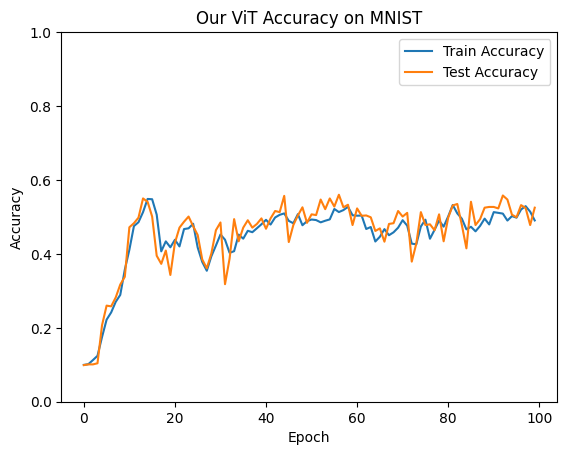

In [ ]:
#plotting 100 epoch mnist data
epochList = range(0, epochs)

plt.plot(epochList, train_accs, label = "Train Accuracy")
plt.plot(epochList, test_accs, label = "Test Accuracy")
#plt.plot(epochList, test_losses, label = "Test Loss")
#plt.plot(epochList, train_losses, label = "Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Our ViT Accuracy on MNIST")
plt.ylim([0,1])
plt.legend()

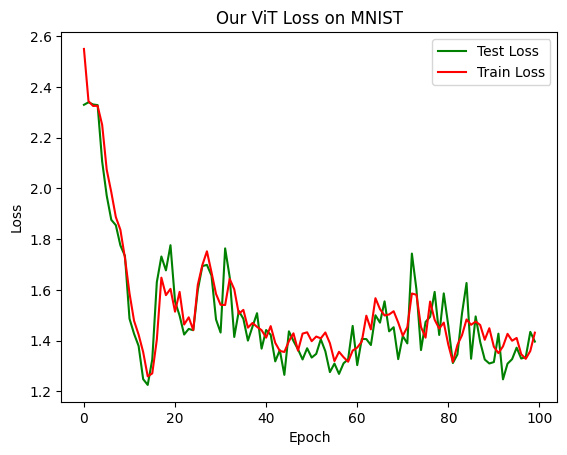

In [ ]:
plt.plot(epochList, test_losses, color = "green", label = "Test Loss")
plt.plot(epochList, train_losses, color = "red", label = "Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Our ViT Loss on MNIST")
plt.legend()

# Transfer Learning on ViT

In [ ]:
import torch
from torchvision import models, transforms
import torch.nn as nn

#load pretrained model
pretrainedModel = models.vit_b_16(weights="IMAGENET1K_V1")
pretrainedModel.eval()

#replace the classification head with our 101 classes
num_classes = 101
pretrainedModel.heads.head = nn.Linear(pretrainedModel.heads.head.in_features, num_classes)

for layer in pretrainedModel.encoder.layers[:10]:
    for param in layer.parameters():
        param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pretrainedModel.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(pretrainedModel.parameters(), lr = 2e-4)
epochs = 50
batch_size = 128

torch.cuda.empty_cache()
finetunedModel, train_losses, test_losses, train_accs, test_accs = modelTraining(pretrainedModel, criterion, optimizer, epochs, train_data, test_data, batch_size, image_size = image_size, channels = 3, device = device)

Batch 0


KeyboardInterrupt: 

# Combining ResNet and ViT





In [ ]:
import torch
from torchvision import models, transforms
import torch.nn as nn

num_classes = 101

#load the pretrained model
trainedViT = models.vit_b_16(weights="IMAGENET1K_V1")
trainedResNet = models.resnet50(pretrained = True)

vit_output_size = trainedViT.heads.head.in_features
resnet_output_size = trainedResNet.fc.in_features

#remove the classification head of each
trainedViT.heads.head = nn.Identity()
trainedResNet.fc = nn.Identity()

#freeze all layers in the ViT model
for param in trainedViT.parameters():
    param.requires_grad = False
#freeze all layers in the ResNet model
for param in trainedResNet.parameters():
    param.requires_grad = False

class CombinedModel(nn.Module):
    def __init__(self, vit_model, resnet_model, num_classes):
        super(CombinedModel, self).__init__()
        self.vit_model = vit_model
        self.resnet_model = resnet_model

        #combining the outputs of each model into a fully connected layer
        combined_output_size = vit_output_size + resnet_output_size

        self.classifier = nn.Linear(combined_output_size, num_classes)

    def forward(self, x):
        vit_features = self.vit_model(x)
        resnet_features = self.resnet_model(x)

        #concatenate features from ViT and ResNet
        combined_features = torch.cat((vit_features, resnet_features), dim=1)

        #pass through the classifier
        output = self.classifier(combined_features)
        return output

combined_model = CombinedModel(trainedViT, trainedResNet, num_classes)

#move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
combined_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(combined_model.parameters(), lr = 0.001)
epochs = 50
batch_size = 128

torch.cuda.empty_cache()
trainedModel, train_losses, test_losses, train_accs, test_accs = modelTraining(combined_model, criterion, optimizer, epochs, train_data, test_data, batch_size, image_size = image_size, channels = 3, device = device)


/ext3/miniforge3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ext3/miniforge3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Batch 0


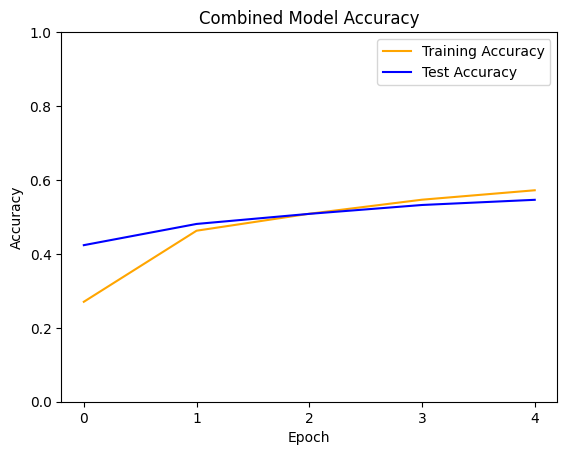

In [ ]:
#first 5 epochs
train_loss = [3.2593,2.2103,1.9594,1.7987,1.6684]
train_acc = [0.2704,0.4627,0.5086,0.5466,0.5721]
test_loss = [2.3602,2.0303,1.9188,1.8234,1.7765]
test_acc = [0.4236,0.4810,0.5083,0.5323,0.5463]

#plt.plot(train_loss, color = "green", label = "Training Loss")
plt.plot(train_acc, color = "orange", label = "Training Accuracy")
#plt.plot(test_loss, color = "red", label = "Test Loss")
plt.plot(test_acc, color = "blue", label = "Test Accuracy")
plt.ylim([0,1])
plt.title("Combined Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks([0,1,2,3,4])
plt.legend()
plt.show()

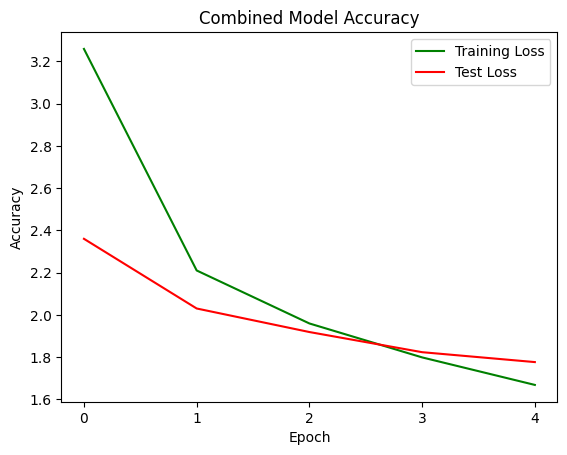

In [ ]:
#first 5 epochs
train_loss = [3.2593,2.2103,1.9594,1.7987,1.6684]
train_acc = [0.2704,0.4627,0.5086,0.5466,0.5721]
test_loss = [2.3602,2.0303,1.9188,1.8234,1.7765]
test_acc = [0.4236,0.4810,0.5083,0.5323,0.5463]

plt.plot(train_loss, color = "green", label = "Training Loss")
#plt.plot(train_acc, color = "orange", label = "Training Accuracy")
plt.plot(test_loss, color = "red", label = "Test Loss")
#plt.plot(test_acc, color = "blue", label = "Test Accuracy")
#plt.ylim([0,1])
plt.title("Combined Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks([0,1,2,3,4])
plt.legend()
plt.show()

Cloning into 'dataset'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 217 (delta 3), reused 9 (delta 2), pack-reused 207 (from 1)
Receiving objects: 100% (217/217), 3.04 MiB | 25.07 MiB/s, done.
Resolving deltas: 100% (107/107), done.


# Stacked Approach

In [12]:
import torch
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F

num_classes = 101

#load the pretrained model
untrainedViT = VisionTransformer(img_size = image_size, patch_size = 16, in_channels = 3, n_classes = 101, embed_dim = 768, depth = 12, n_heads = 12, mlp_ratio = 4.0, qkv_bias = True, p = 0.1, attn_p = 0.1)

trainedResNet = models.resnet101(pretrained = True)

resnet_output_size = trainedResNet.fc.in_features

#remove the classification head
trainedResNet.fc = nn.Identity()
trainedResNet.avgpool = nn.Identity()

#freeze all layers in the ResNet model
for param in trainedResNet.parameters():
    param.requires_grad = False

class StackedModel(nn.Module):
    def __init__(self, vit_model, resnet_model, num_classes):
        super(StackedModel, self).__init__()
        self.vit_model = vit_model
        self.resnet_model = resnet_model

        #add a convolutional layer to match channels=3
        self.conv_proj = torch.nn.Conv2d(in_channels=2048, out_channels=3, kernel_size=1)


    def forward(self, x):
        resnet_features = self.resnet_model(x)

        batch_size = resnet_features.size(0)
        resnet_features = resnet_features.view(batch_size, 2048, 7, 7)

        resnet_features_with_channels = self.conv_proj(resnet_features)

        resized_features = F.interpolate(resnet_features_with_channels, size=(224, 224), mode='bilinear', align_corners=False)

        out = self.vit_model(resized_features)

        return out


stacked_model = StackedModel(untrainedViT, trainedResNet, num_classes)
state_dict = torch.load("stacked_save5.pth")
stacked_model.load_state_dict(state_dict)

#move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
stacked_model.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(stacked_model.parameters(), lr = 0.001)
optimizer = torch.optim.SGD(stacked_model.parameters(), lr=0.12, momentum=0.9)
epochs = 50
batch_size = 128

torch.cuda.empty_cache()
trainedModel, train_losses, test_losses, train_accs, test_accs = modelTraining(stacked_model, criterion, optimizer, epochs, train_data, test_data, batch_size, image_size = image_size, channels = 3, device = device)


/ext3/miniforge3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ext3/miniforge3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_6426/3143234490.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-model

Batch 0


KeyboardInterrupt: 

In [1]:
#stacked
                    #adamW 0.001   #SGD 0.05, 0.9m   #SGD .1 0.9m   #SGD .15 0.9m     #SGD .2 0.9m    #SGD .12 0.9m
train_accuracies = [0.0099,0.0181,  0.0276,           .048,          0.0783,         0.0867,0.1001,   .1146]
train_losses = [4.7009,4.5174,      4.4252,           4.15,           3.9199,        3.6945,3.7813,   3.7053]
test_accuracies = [0.0108,0.0235,   0.0386,           .068,         0.09102,         0.1055,0.1083,   .1332]
test_losses = [4.6585,4.4483,       4.2500,           3.95,         3.7858,          3.6945,3.6898,   3.5526]

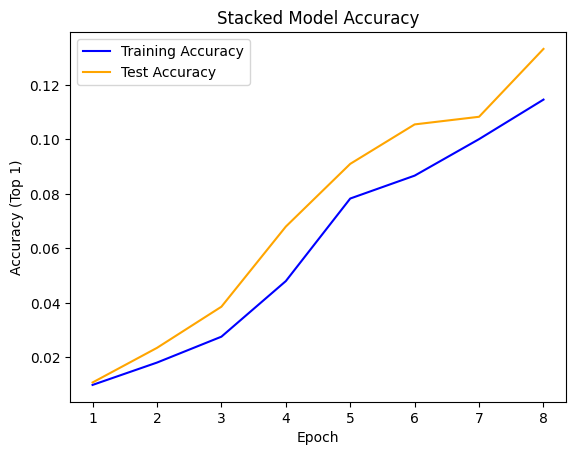

In [10]:
import matplotlib.pyplot as plt

plt.title("Stacked Model Accuracy")
plt.plot(train_accuracies, label = "Training Accuracy", color = "blue")
#plt.plot(train_losses, label = "Training Loss", color = "green")
plt.plot(test_accuracies, label = "Test Accuracy", color = "orange")
#plt.plot(test_losses, label = "Test Loss", color = "red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (Top 1)")
plt.xticks(range(0,8), [1,2,3,4,5,6,7,8])
plt.legend()
plt.show()


# ONNX Export and Netron Visualization

In [30]:
#this didnt end up being a great visual, we didnt use it
import torch.onnx

# Load the pretrained model
trainedResNet = models.resnet50(pretrained=True)

untrainedViT = VisionTransformer(img_size = image_size, patch_size = 16, in_channels = 3, n_classes = 101, embed_dim = 768, depth = 1, n_heads = 1, mlp_ratio = 4.0, qkv_bias = True, p = 0.1, attn_p = 0.1)

vit_output_size = untrainedViT.head.in_features
resnet_output_size = trainedResNet.fc.in_features

# Remove the classification head of each
trainedResNet.fc = nn.Identity()
untrainedViT.head = nn.Identity()

# Freeze all layers in both models
for param in trainedViT.parameters():
    param.requires_grad = False
for param in trainedResNet.parameters():
    param.requires_grad = False

class SubModelWrapper(nn.Module):
    def __init__(self, model):
        super(SubModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

class AttnFusionModelExportable(nn.Module):
    def __init__(self, vit_model, resnet_model, num_classes):
        super(AttnFusionModelExportable, self).__init__()
        self.vit_model = vit_model
        self.resnet_model = resnet_model

        self.vit_model = SubModelWrapper(self.vit_model)
        self.resnet_model = SubModelWrapper(self.resnet_model)

        # Calculate combined feature size
        combined_output_size = vit_output_size + resnet_output_size

        # Create attention fusion layer
        self.attention_fusion = AttentionFusion(combined_output_size)

        # Final classifier
        self.classifier = nn.Linear(combined_output_size, num_classes)

    def forward(self, x):
        vit_features = self.vit_model(x)
        resnet_features = self.resnet_model(x)
        fused_features = self.attention_fusion(vit_features, resnet_features)
        output = self.classifier(fused_features)
        return output

attn_fusion_model = AttnFusionModel2(untrainedViT, trainedResNet, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
example_input = torch.randn(1, 3, 224, 224).to(device)
attn_fusion_model.to(device)

torch.onnx.export(
    attn_fusion_model,  # PyTorch model
    example_input,  # Example input tensor
    "model_export.onnx",  # Output file name
    export_params=True,  # Store the trained parameters
    opset_version=17,  # ONNX version (choose compatible opset)
    do_constant_folding=True,  # Optimize constant expressions
    input_names=['input'],  # Model input name(s)
    output_names=['output'],  # Model output name(s)
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Dynamic batching
)



/tmp/ipykernel_5220/3301781817.py:25: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if dim != self.dim:


In [ ]:
!pip install netron

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.8 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
!/home/jrt9288/.local/bin/netron /home/jrt9288/Project/model_export.onnx

Serving '/home/jrt9288/Project/model_export.onnx' at http://localhost:8080
^C

Stopping http://localhost:8080


# Sample Images

/tmp/ipykernel_5220/350100561.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("finalMultiheadModel.pth")
/tmp/ipykernel_5220/350100561.py:28: Use

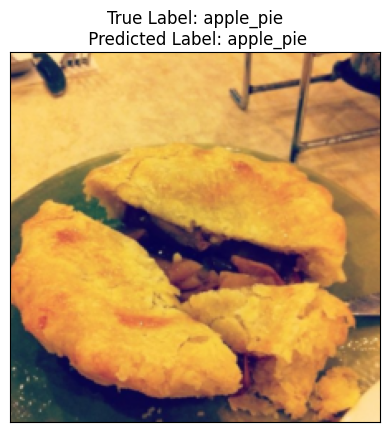

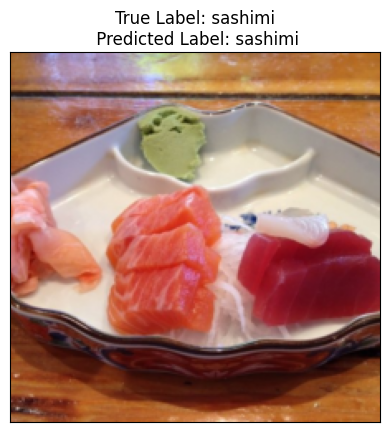

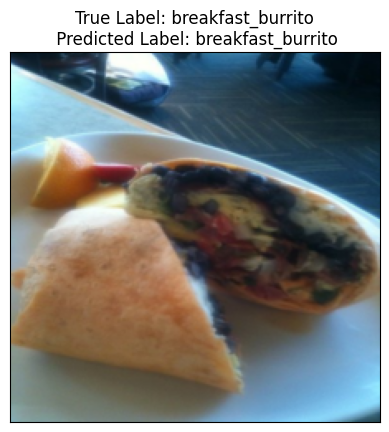

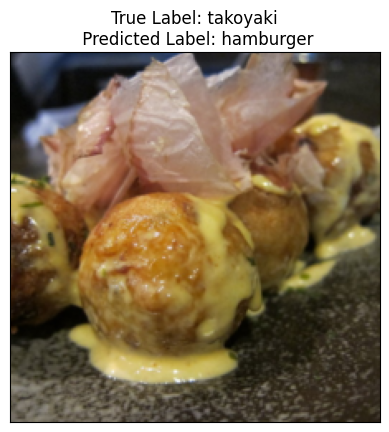

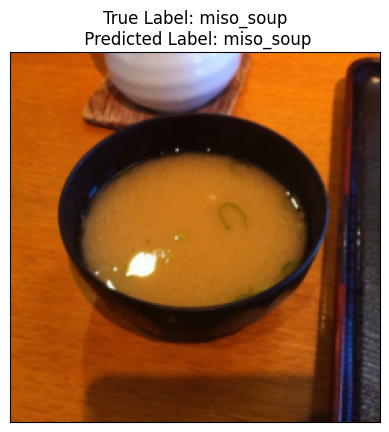

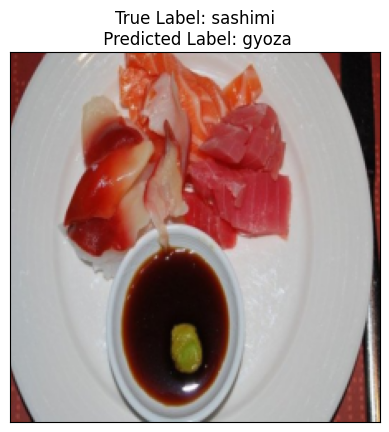

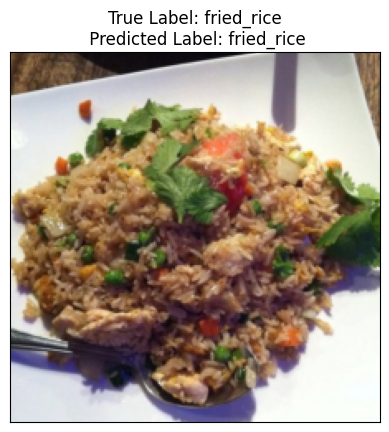

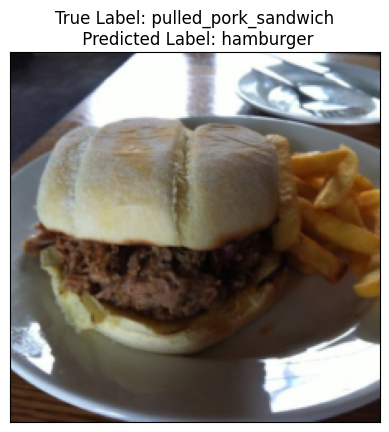

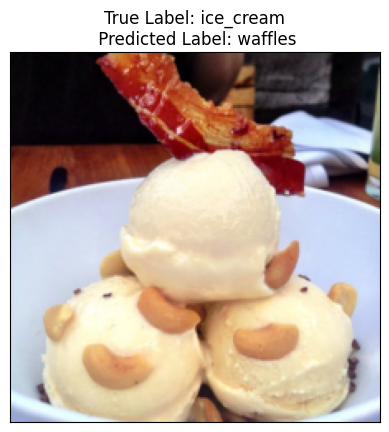

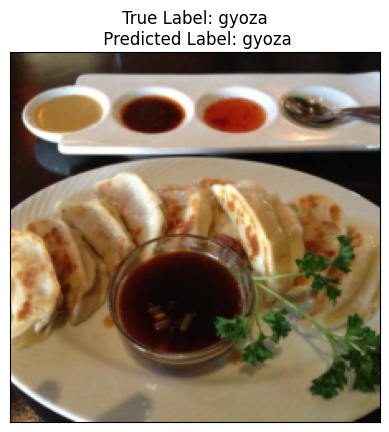

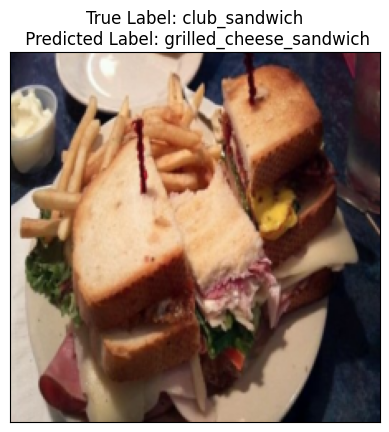

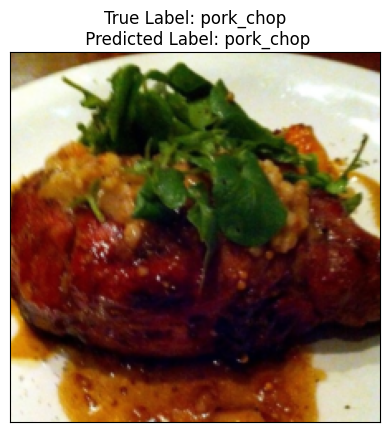

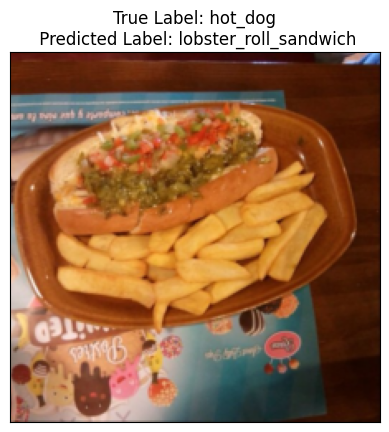

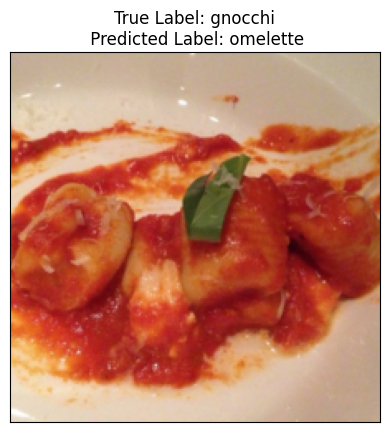

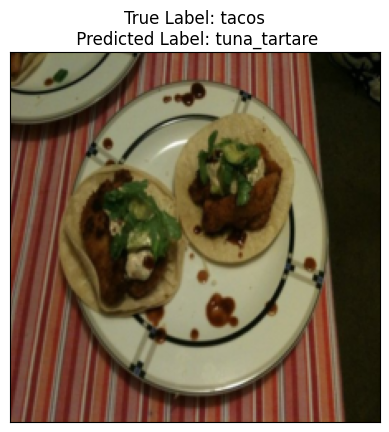

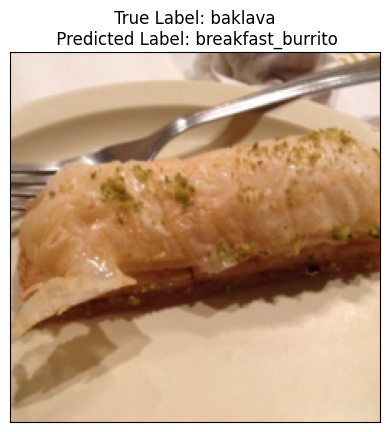

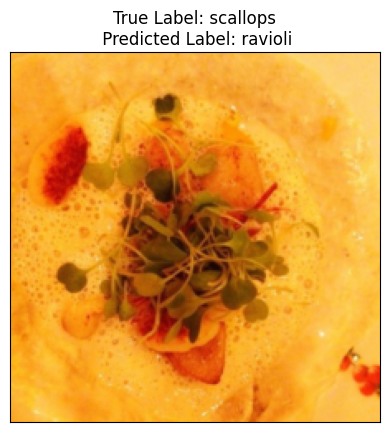

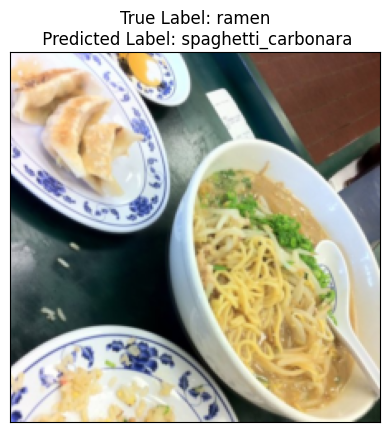

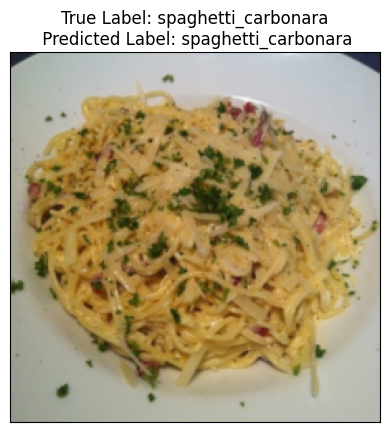

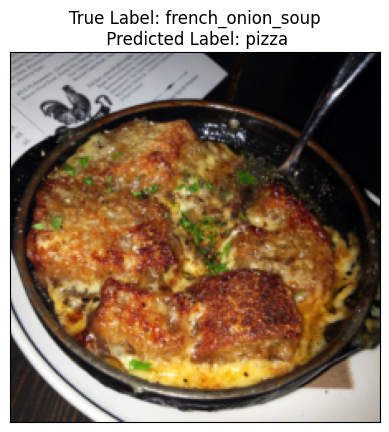

In [28]:
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F

#create the combined model
attn_fusion_model = AttnFusionModel2(trainedViT, trainedResNet, num_classes)
state_dict = torch.load("finalMultiheadModel.pth")
attn_fusion_model.load_state_dict(state_dict)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attn_fusion_model.to(device)

test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

parent_dir = "data/food-101/images"
names = [f for f in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, f))]
names = sorted(names)

run = 0
for image, label in test_loader:
    run+=1
    image_tensor = image.to(device)
    image = image[0]
    image_numpy = image.permute(1, 2, 0).numpy()

    pred = attn_fusion_model(image_tensor)
    softmaxed = np.array(F.softmax(pred).detach().cpu())
    index = np.argmax(softmaxed)

    indices = np.argsort(softmaxed)

    plt.imshow(image_numpy)
    plt.title(f"True Label: {names[label]}\n Predicted Label: {names[index]}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

    if run == 20:
        break




# Combinination using Multi-Head Attention

In [22]:
import torch
from torchvision import models, transforms
import torch.nn as nn

num_classes = 101

#load the pretrained models
trainedViT = models.vit_b_16(weights="IMAGENET1K_V1")
trainedResNet = models.resnet50(pretrained=True)

vit_output_size = trainedViT.heads.head.in_features
resnet_output_size = trainedResNet.fc.in_features

#remove the classification head of each
trainedViT.heads.head = nn.Identity()
trainedResNet.fc = nn.Identity()

#freeze all layers in both models
for param in trainedViT.parameters():
    param.requires_grad = False
for param in trainedResNet.parameters():
    param.requires_grad = False


class AttnFusionModel2(nn.Module):
    def __init__(self, vit_model, resnet_model, num_classes):
        super(AttnFusionModel2, self).__init__()
        self.vit_model = vit_model
        self.resnet_model = resnet_model

        #calculate combined feature size
        combined_output_size = vit_output_size + resnet_output_size
        
        #create attention fusion layer
        self.attention_fusion = Attention(dim = combined_output_size, n_heads = 4, qkv_bias = True)

        #final classifier
        self.classifier = nn.Linear(combined_output_size, num_classes)

    def forward(self, x):
        vit_features = self.vit_model(x)
        resnet_features = self.resnet_model(x)
        #print(resnet_features.shape)
        combined = torch.cat((vit_features, resnet_features), dim=1)  #concatenate features
        combined = combined.unsqueeze(1)
        #print(combined.shape)
        fused_features = self.attention_fusion(combined)
        output = self.classifier(fused_features)
        output = output.view(output.shape[0],101)
        return output

#create the combined model
attn_fusion_model = AttnFusionModel2(trainedViT, trainedResNet, num_classes)
state_dict = torch.load("secondVersion.pth")
attn_fusion_model.load_state_dict(state_dict)

#move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attn_fusion_model.to(device)

#set up training parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(attn_fusion_model.parameters(), lr=0.01, momentum=0.9)
epochs = 6
batch_size = 128

torch.cuda.empty_cache()
trainedModel, train_losses, test_losses, train_accs, test_accs = modelTraining(attn_fusion_model, criterion, optimizer, epochs, train_data, test_data, batch_size, image_size=image_size, channels=3, device=device)



/tmp/ipykernel_5220/3379498379.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("secondVersion.pth")


KeyboardInterrupt: 

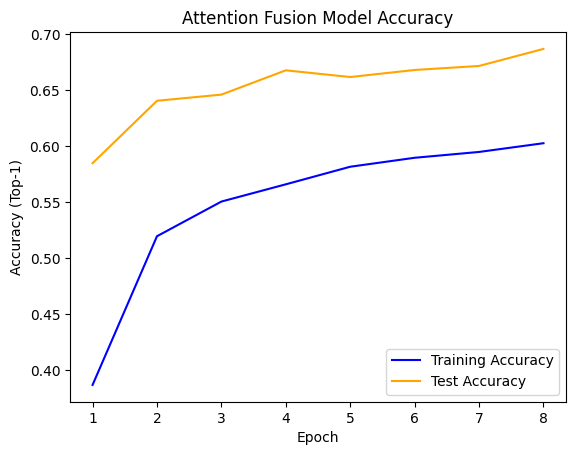

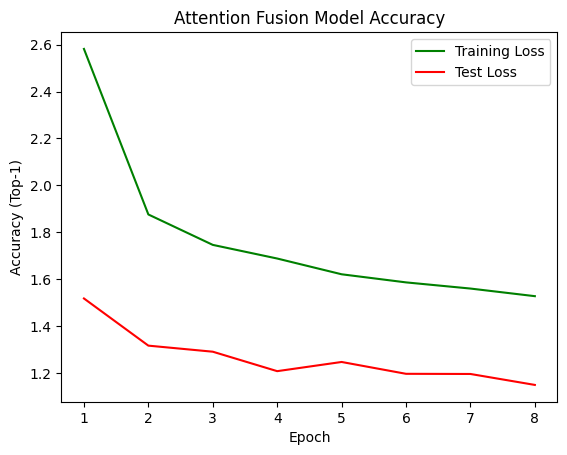

In [10]:
#from second round
#Epoch 1: Training Loss: 1.7459, Training Accuracy: 0.5504, Test Loss: 1.2902, Test Accuracy: 0.6459
#Epoch 2: Training Loss: 1.6877, Training Accuracy: 0.5658, Test Loss: 1.2072, Test Accuracy: 0.6676
#Epoch 3: Training Loss: 1.6205, Training Accuracy: 0.5815, Test Loss: 1.2464, Test Accuracy: 0.6616
#Epoch 4: Training Loss: 1.5859, Training Accuracy: 0.5895, Test Loss: 1.1959, Test Accuracy: 0.6679
#Epoch 5: Training Loss: 1.5596, Training Accuracy: 0.5947, Test Loss: 1.1952, Test Accuracy: 0.6715
#Epoch 6: Training Loss: 1.5271, Training Accuracy: 0.6025, Test Loss: 1.1485, Test Accuracy: 0.6867

#preprended with metrics from an earlier round of training
train_losses = [2.5818521976470947, 1.8756526708602905] + [1.7459,1.6877,1.6205,1.5859,1.5596,1.5271]
train_accs = [0.3866666555404663, 0.519445538520813] + [0.5504,0.5658,0.5815, 0.5895,.5947,0.6025]
test_losses = [1.5173165798187256, 1.3160858154296875] + [1.2902,1.2072,1.2464,1.1959,1.1952,1.1485]
test_accs = [0.5846336483955383, 0.6403960585594177] + [.6459, 0.6676,0.6616,0.6679,0.6715,0.6867]

plt.plot(train_accs, label = "Training Accuracy", color = "blue")
#plt.plot(train_losses, label = "Training Loss", color = "green")
plt.plot(test_accs, label = "Test Accuracy", color = "orange")
#plt.plot(test_losses, label = "Test Loss", color = "red")
plt.xticks(range(0, 8), range(1, 8+1))
plt.xlabel("Epoch")
plt.ylabel("Accuracy (Top-1)")
plt.title("Attention Fusion Model Accuracy")
plt.legend()
plt.show()

#plt.plot(train_accs, label = "Training Accuracy", color = "blue")
plt.plot(train_losses, label = "Training Loss", color = "green")
#plt.plot(test_accs, label = "Test Accuracy", color = "orange")
plt.plot(test_losses, label = "Test Loss", color = "red")
plt.xticks(range(0, 8), range(1, 8+1))
plt.xlabel("Epoch")
plt.ylabel("Accuracy (Top-1)")
plt.title("Attention Fusion Model Accuracy")
plt.legend()
plt.show()

In [16]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

attn_fusion_model = AttnFusionModel2(trainedViT, trainedResNet, num_classes)
stacked_model = StackedModel(untrainedViT, trainedResNet, num_classes)

print(f"The attention fusion model has {count_trainable_parameters(attn_fusion_model)} trainable parameters.")

print(f"The stacked model has {count_trainable_parameters(stacked_model)} trainable parameters.")

The attention fusion model has 32015205 trainable parameters.
The stacked model has 85882472 trainable parameters.


# Testing Different Numbers of Heads

In [9]:
import torch
from torchvision import models, transforms
import torch.nn as nn

accuracy = []
for heads in range(1, 5):
    num_classes = 101

    '''
    #already ran
    if heads == 1 or heads == 2:
        continue
    '''
    #doesnt work, divisibility issues
    if heads == 3:
        continue
    
    #load the pretrained models
    trainedViT = models.vit_b_16(weights="IMAGENET1K_V1")
    trainedResNet = models.resnet50(pretrained=True)
    
    vit_output_size = trainedViT.heads.head.in_features
    resnet_output_size = trainedResNet.fc.in_features
    
    #remove the classification head of each
    trainedViT.heads.head = nn.Identity()
    trainedResNet.fc = nn.Identity()

    #freeze all layers in both models
    for param in trainedViT.parameters():
        param.requires_grad = False
    for param in trainedResNet.parameters():
        param.requires_grad = False


    class AttnFusionModel2(nn.Module):
        def __init__(self, vit_model, resnet_model, num_classes):
            super(AttnFusionModel2, self).__init__()
            self.vit_model = vit_model
            self.resnet_model = resnet_model
    
            #calculate combined feature size
            combined_output_size = vit_output_size + resnet_output_size
    
            #create attention fusion layer
            self.attention_fusion = Attention(dim = combined_output_size, n_heads = heads, qkv_bias = True)
    
            #final classifier
            self.classifier = nn.Linear(combined_output_size, num_classes)
    
        def forward(self, x):
            vit_features = self.vit_model(x)
            resnet_features = self.resnet_model(x)
            #print(resnet_features.shape)
            combined = torch.cat((vit_features, resnet_features), dim=1)  #concatenate features
            combined = combined.unsqueeze(1)
            #print(combined.shape)
            fused_features = self.attention_fusion(combined)
            output = self.classifier(fused_features)
            output = output.view(output.shape[0],101)
            return output

    #create the combined model
    attn_fusion_model = AttnFusionModel2(trainedViT, trainedResNet, num_classes)
    
    #move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    attn_fusion_model.to(device)
    
    #set up training parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(attn_fusion_model.parameters(), lr=0.01, momentum=0.9)
    epochs = 1
    batch_size = 128
    
    torch.cuda.empty_cache()
    trainedModel, train_losses, test_losses, train_accs, test_accs = modelTraining(attn_fusion_model, criterion, optimizer, epochs, train_data, test_data, batch_size, image_size=image_size, channels=3, device=device)

    accuracy += train_accs

print(f"Test Accuracy after one epochusing:\nOne Head: {accuracy[0]}\nTwo Heads: {accuracy[1]}\nThree Heads: {accuracy[2]}\nFour Heads: {accuracy[3]}")

/ext3/miniforge3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ext3/miniforge3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Batch 120
Batch 130
Batch 140
Batch 150
Batch 160
Batch 170
Batch 180
Batch 190
Batch 200
Batch 210
Batch 220
Batch 230
Batch 240
Batch 250
Batch 260
Batch 270
Batch 280
Batch 290
Epoch 1: Training Loss: 3.0614, Training Accuracy: 0.3042, Test Loss: 1.7317, Test Accuracy: 0.5430


IndexError: list index out of range

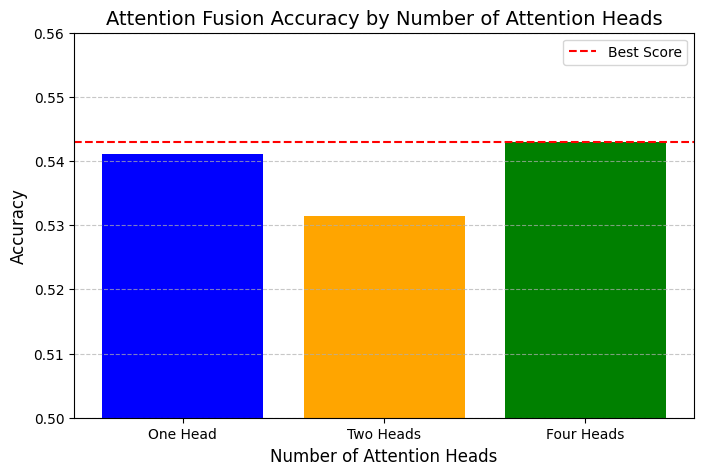

In [19]:
import matplotlib.pyplot as plt

# Data for the bar graph
head_types = ['One Head', 'Two Heads', 'Four Heads']
accuracies = [0.5411, 0.5314, 0.5430] #data from experiment above
               #1       2      3
# Create the bar graph
plt.figure(figsize=(8, 5))
plt.bar(head_types, accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Number of Attention Heads', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Attention Fusion Accuracy by Number of Attention Heads', fontsize=14)
plt.ylim(0.5, 0.56) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(0.5430, color = "red", linestyle = "--", label = "Best Score")
plt.legend()
plt.show()
